<a href="https://colab.research.google.com/github/Bakame1/ET5_Quantum_Computing_Lab/blob/main/TP4_QFT/TP4_QFT_MB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 4 : Transformée de Fourier quantique

In [1]:
# Exécuter seulement dans Google Colab
!pip install myqlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.2/833.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.5/648.5 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.0/661.0 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.6/285.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.0/911.0 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 742.5/742.5 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.0 MB/s eta 0:00:00
   ━━━

In [2]:
import numpy as np

from qat.lang import QRoutine, H, PH, CNOT, RY, RZ, Z, X, CCNOT, Program, SWAP
from qat.qpus import get_default_qpu

qpu = get_default_qpu()

def display_result(circuit, nbshots=0, idx=None):
    result = qpu.submit(circuit.to_job(nbshots=nbshots, qubits=idx))
    if nbshots:
        tmp = {}
        for sample in result:
            state = sample.state
            if not state in tmp:
                tmp[state] = 0.
            tmp[sample.state] += sample.probability
        for state, proba in tmp.items():
            print("Etat %s: probabilité %s" % (state, proba))
    else:
        for sample in result:
            print("Etat %s: probabilité %s, amplitude %s" % (sample.state, sample.probability, sample.amplitude))

def get_result(circuit, idx=None):
    result = qpu.submit(circuit.to_job(nbshots=0, qubits=idx))
    states = []
    amplitudes = []
    for sample in result:
            states.append(sample.state.int)
            if idx:
                amplitudes.append(sample.probability)
            else:
                amplitudes.append(sample.amplitude)
    return np.array(states), np.array(amplitudes)

import matplotlib.pyplot as plt

def encode(x):
    from qat.lang.models import KPTree

    return KPTree(x).get_routine(0)

<div style="display:none;">
\[
\newcommand{\ket}[1]{\left| #1 \right\rangle}
\newcommand{\bra}[1]{\left\langle #1 \right|}
\newcommand{\braket}[2]{\left\langle #1 \mid #2 \right\rangle}
\]
</div>

## Transformée de Fourier quantique

La transformée de Fourier quantique [https://fr.wikipedia.org/wiki/Transform%C3%A9e_de_Fourier_quantique], ou Quantum Fourier Transform (QFT) en anglais, est l'équivalent quantique de la transformée de Fourier discrète.

### Rappels : Transformée de Fourier discrète

La transformée de Fourier discrète [https://fr.wikipedia.org/wiki/Transformation_de_Fourier_discr%C3%A8te] est un outil mathématique utilisé en traitement du signal. Elle permet l'étude du spectre d'un signal échantillonné dans le domaine des fréquences.

Soit un signal $s$ de $N=2^n$ échantillons $s_0, s_1, \dots, s_{N-1}$, sa transformation de Fourier discrète $\hat{s}$ est définie par les $N$ éléments $\hat{s}_0, \hat{s}_1, \dots, \hat{s}_{N-1}$ tels que

$$
\hat{s}_k = \sum_{j=0}^{N-1} s_j e^{-2i \pi k \frac{j}{N}}.
$$

### Définition : Transformée de Fourier quantique

La transformée de Fourier quantique (QFT) fonctionne de la même manière que la transformée de Fourier discrète (DFT) (à un signe prêt dans l'exponentielle) mais agit sur un état quantique $\ket{s} = \sum_{i=0}^{N-1}s_i \ket{i}$. Elle renvoie alors un autre état quantique $\ket{\hat{s}} = \sum_{i=0}^{N-1}\hat{s}_i \ket{i}$ tel que

$$
\hat{s}_k = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1}s_j e^{2i \pi k \frac{j}{N}}
$$

On peut aussi formuler la QFT de la façon suivante

$$
QFT \ket{x} = \bigotimes_{k={n-1}}^0 \left( \ket{0} + e^{2i \pi x \frac{2^k}{2^n}} \ket{1} \right),
$$

ce qui correspond au produit tensoriel de $n$ états à un qubit. On peut alors modifier chaque qubit $k$ de notre état quantique $x$ l'un à la suite de l'autre en utilisant l'opérateur $U_k$ qui réalise la transformation suivante

$$
U_k \ket{x_0 \dots x_{n-1}} = \ket{x_0 \dots x_{k-1}} \otimes \left( \ket{0} + e^{2i\pi x \frac{2^k}{2^n}}\ket{1} \right) \otimes \ket{x_{k+1}\dots x_{n-1}}.
$$

Pour ce faire on peut utiliser une porte H pour créer une superposition uniforme entre $\ket{0}$ et $\ket{1}$ sur le qubit, puis appliquer des phases contrôlées comme l'illustre le GIF ci dessous

<center>

![Gif](https://github.com/Bakame1/ET5_Quantum_Computing_Lab/blob/main/TP4_QFT/img/qft_gif.gif?raw=1)

*source : [https://pennylane.ai/qml/demos/tutorial_qft]*
</center>

Dans ce TP nous allons implémenter le QFT et faire des expériences avec.

### Implémentation de la QFT

Dans un premier temps, concentrons nous sur l'implémentation de la QFT. Il nous faut définir l'opérateur $U_k$ qui agit sur le $k$-ème qubit de l'état à $n$ qubits $x$. La porte phase $PH(2 \theta)$ peut être utilisée pour appliquer le $e^{i\theta}$.


**Question 1** : Implémenter l'opérateur $U_k$ pour $n$ et $k$ qui varient

In [3]:
def U_k(n, k):
    rout = QRoutine()
    wires = rout.new_wires(n) # On déclare les n qubits pour pouvoir les sélectionner

    # 1. Porte Hadamard sur le qubit k
    rout.apply(H, wires[k])

    # 2. Rotations contrôlées par les qubits supérieurs (j > k)
    # Dans la QFT standard, on applique des phases de plus en plus petites
    # à mesure que le qubit de contrôle est éloigné.
    for j in range(k + 1, n):
        # L'angle théorique est pi / 2^(distance)
        distance = j - k
        theta = np.pi / (2 ** distance)

        #theta à la porte PH
        rout.apply(PH(theta).ctrl(), wires[j], wires[k])

    return rout

**Question 2** : Implémenter la *qft* en utilisant l'opérateur $U_k$ implémenté plus haut

In [4]:
def qft(n):
    rout = QRoutine()
    wires = rout.new_wires(n)

    # 1. Application séquentielle des opérateurs U_k
    # On parcourt chaque qubit k de 0 à n-1
    for k in range(n):
        # On applique la routine U_k définie à la Question 1
        rout.apply(U_k(n, k), wires)

    # 2. Inversion de l'ordre des qubits (Bit Reversal)
    # C'est une étape cruciale : sans elle, la sortie est "à l'envers".
    # On échange le qubit i avec son symétrique n-1-i.
    for i in range(n // 2):
        rout.apply(SWAP, wires[i], wires[n - 1 - i])

    return rout

La QFT est déjà implémentée dans myqlm et nous allons donc pouvoir comparer notre circuit quantique à celui ci

In [5]:
n = 4
qft(n).display()

from qat.lang.AQASM.qftarith import QFT
QFT(n).display()

## Recherche de fréquence

### Signal sinusoïdal simple

La QFT peut servir à retrouver la ou les fréquences qui constituent un signal périodique. Le cas le plus simple est celui du signal sinusoïdal, qui se caractérise par une seule fréquence dans le domaine de Fourier. Nous allons donc tester notre algorithme de la QFT sur un signal sinusoïdal $s$ de fréquence $f$ tel que

$$
s(x) = cos(2 \pi f x)
$$

On va alors échantillonner le signal sur $N = 2^n$ points sur $[0,1]$ pour ensuite appliquer la transformée de Fourier.

**Question 3** :  Créer le vecteur du signal échantilloné $s$ et l'afficher à l'aide de matplotlib (plt.plot)

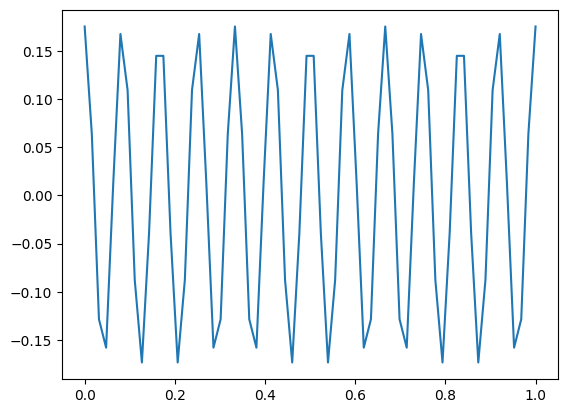

In [13]:
n = 6
N = 2**n

f = 12

x = np.linspace(0, 1, N)
s = np.cos(2* np.pi * f * x)
s /= np.linalg.norm(s)

plt.plot(x, s)
plt.show()

On peut alors encoder le vecteur du signal $s$ dans un état quantique sur $n$ qubits (la fonction *encode* est fournie en début du notebook pour plus de simplicité). La sortie du circuit quantique d'encodage (états quantiques et amplitudes) peuvent être obtenus grâce à la fonction *get_result* et on vérifie qu'on retrouve bien le signal $s$

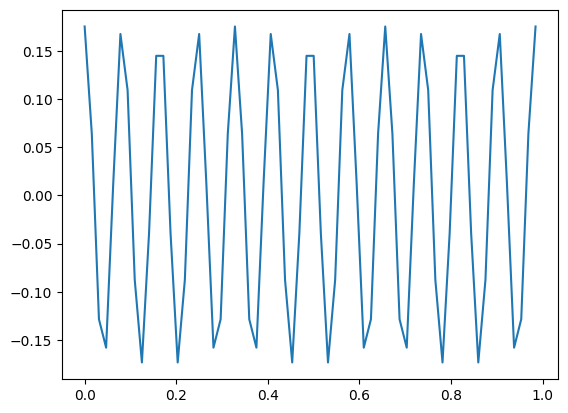

In [14]:
circuit = encode(s)

states, amplitudes = get_result(circuit)
plt.plot(states/ 2**n, amplitudes)
plt.show()

Maintenant, nous pouvons tester notre QFT sur le signal encodé. Il suffit de
1) Encoder s
2) Appliquer la QFT
3) Inverser l'ordre des qubits dans le résultat final (oui, la QFT change la convention de "Bit de poids fort" vers "Bit de poids faible" et vice versa)

**Question 5** : Appliquer la QFT sur le signal $s$ et observer le résultat à l'aide de la fonction get_result et de matplotlib

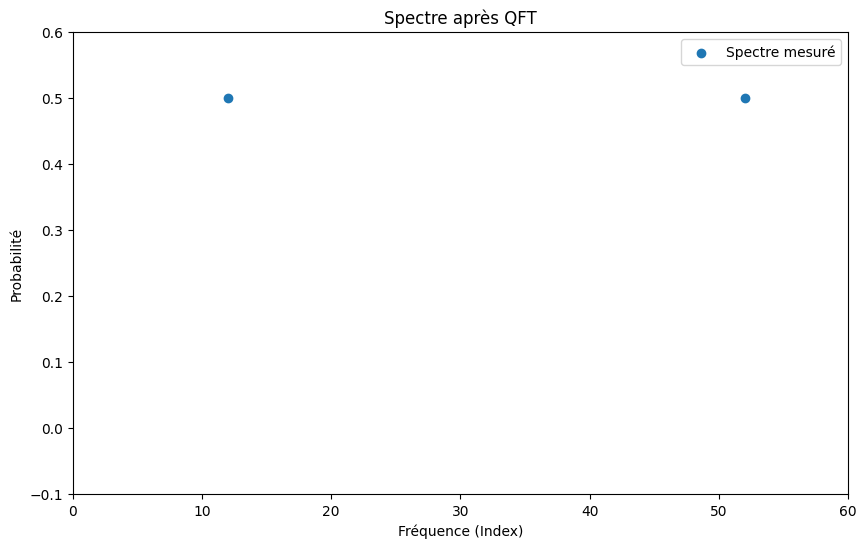

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Préparation du signal
t = np.linspace(0, 1, N, endpoint=False)
s = np.cos(2 * np.pi * f * t)

# 2. Normalisation (CRUCIAL pour l'encodage quantique)
s_norm = s / np.linalg.norm(s)

# 3. Circuit
rout = QRoutine()
qubits = rout.new_wires(n)

# Encodage
rout.apply(encode(s_norm), qubits)

# QFT
rout.apply(qft(n), qubits)

# 4. Simulation
circuit = rout.to_circ()
result = qpu.submit(circuit.to_job())

# Récupération des probabilités
states, probs = [], []
for sample in result:
    states.append(sample.state.int)
    probs.append(sample.probability)

# 5. Affichage
plt.figure(figsize=(10, 6))
plt.scatter(states, probs, label="Spectre mesuré") # Barplot est souvent plus lisible

plt.xlim(0, 60)       # Axe X : de 0 à 60
plt.ylim(-0.1, 0.6)   # Axe Y : de -0.1 à 0.5
plt.xlabel("Fréquence (Index)")
plt.ylabel("Probabilité")
plt.legend()
plt.title("Spectre après QFT")
plt.show()

On peut aussi comparer la courbe obtenue à celle renvoyer par la FFT de numpy

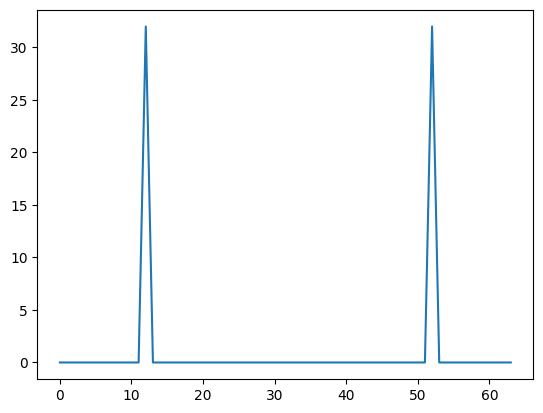

In [20]:
plt.plot(np.fft.fft(s))
plt.show()

### Modulation de signal sinusoïdal

Pour faire un peu plus complexe, nous allons étudié le cas de la modulation de signal. L'idée ici va être de faire intéragir une sinusoïde de fréquence élevée $f_1$, l'onde porteuse, et une sinusoïde de fréquence $f_2$ plus faible qui sera le signal d'entrée. Le signal général transmis est alors de la forme

$$
s(x) = cos(2 \pi f_1 x) cos(2  \pi f_2  x)
$$

Comme deux sinusoïdes coexistent dans le signal on devrait apercevoir deux pics dans le domaine de Fourier

- un premier à $f_1 - f_2$
- un second à $f_1 + f_2$

**Question 6** :  Créer le vecteur du signal échantilloné $s$ et l'afficher à l'aide de matplotlib (plt.plot)

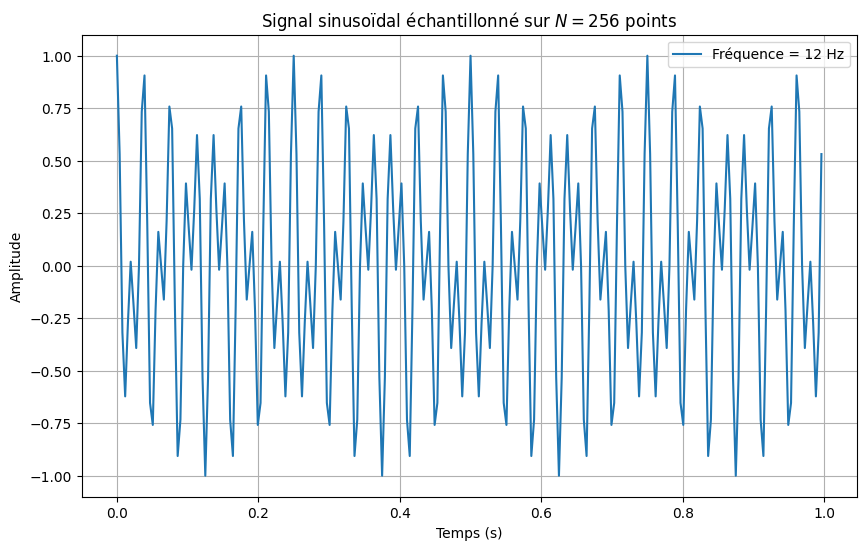

In [23]:
n = 8
N = 2**n

f1 = 40
f2 = 12

# 1. Création du vecteur temps
# On génère N points espacés régulièrement entre 0 (inclus) et 1 (exclu)
t = np.linspace(0, 1, N, endpoint=False)

# 2. Création du signal s(x) = cos(2*pi*f1*x)*cos(2*pi*f2*x)
s = np.cos(2 * np.pi * f1 * t)*np.cos(2 * np.pi * f2 * t)

# 3. Affichage
plt.figure(figsize=(10, 6))
plt.plot(t, s, label=f"Fréquence = {f} Hz")
plt.title(f"Signal sinusoïdal échantillonné sur $N={N}$ points")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

**Question 7** : Appliquer la QFT sur le signal $s$ et observer le résultat à l'aide de la fonction get_result et de matplotlib

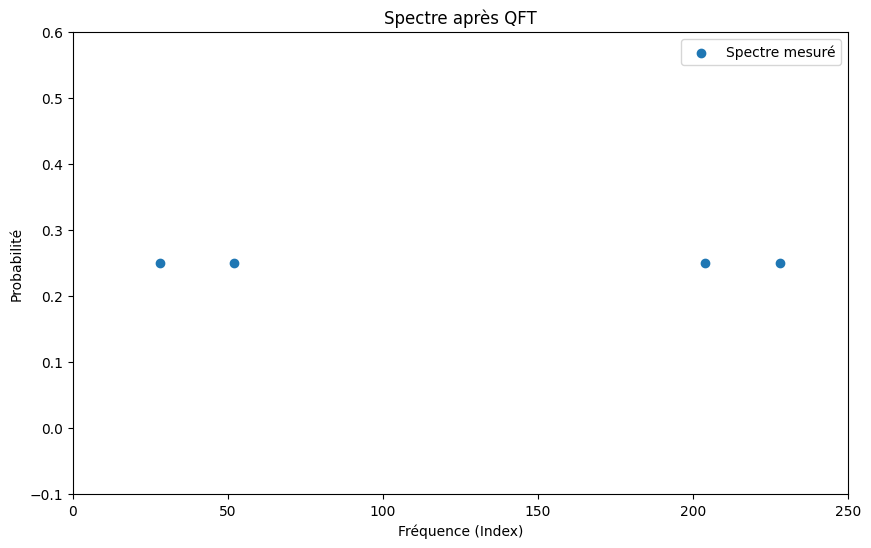

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Préparation du signal
t = np.linspace(0, 1, N, endpoint=False)
s = np.cos(2 * np.pi * f1 * t)*np.cos(2 * np.pi * f2 * t)

# 2. Normalisation (CRUCIAL pour l'encodage quantique)
s_norm = s / np.linalg.norm(s)

# 3. Circuit
rout = QRoutine()
qubits = rout.new_wires(n)

# Encodage
rout.apply(encode(s_norm), qubits)

# QFT
rout.apply(qft(n), qubits)

# 4. Simulation
circuit = rout.to_circ()
result = qpu.submit(circuit.to_job())

# Récupération des probabilités
states, probs = [], []
for sample in result:
    states.append(sample.state.int)
    probs.append(sample.probability)

# 5. Affichage
plt.figure(figsize=(10, 6))
plt.scatter(states, probs, label="Spectre mesuré") # Barplot est souvent plus lisible

plt.xlim(0, 250)       # Axe X : de 0 à 60
plt.ylim(-0.1, 0.6)   # Axe Y : de -0.1 à 0.5
plt.xlabel("Fréquence (Index)")
plt.ylabel("Probabilité")
plt.legend()
plt.title("Spectre après QFT")
plt.show()


On peut aussi comparer la courbe obtenue à celle renvoyer par la FFT de numpy

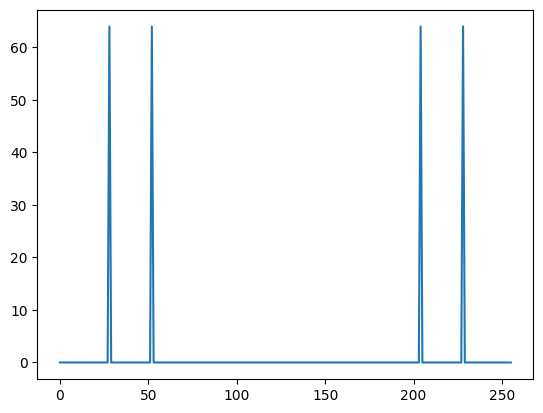

In [25]:
plt.plot(np.fft.fft(s))
plt.show()

<div style="display:none;">
\[
\newcommand{\ket}[1]{\left| #1 \right\rangle}
\newcommand{\bra}[1]{\left\langle #1 \right|}
\newcommand{\braket}[2]{\left\langle #1 \mid #2 \right\rangle}
\]
</div>

## Estimation de Phase Quantique (QPE)

L'algorithme d'estimation de phase quantique (QPE) [https://fr.wikipedia.org/wiki/Algorithme_d%27estimation_de_phase_quantique] permet d'estimer les valeurs propres d'un opérateur unitaire. Imaginons que nous ayons un opérateur unitaire $U$, alors ses valeurs propres sont sur le cercle unitaire (nombre complexe de module $1$). On peut donc les identifier à leur phase dans le cercle unitaire. Il y a équivalence à prendre les phases dans $(-\pi, \pi)$ et $(0, 2 \pi)$.

<center>
    <img src="https://github.com/Bakame1/ET5_Quantum_Computing_Lab/blob/main/TP4_QFT/img/unit_circle.png?raw=1" width=350/>
</center>

Pour rappel, si $\ket{\psi}$ est vecteur propre de $U$, de valeur propre $\lambda = e^{2i \pi \theta}$ alors $U \ket{\psi} = e^{2i\pi \theta} \ket{\psi}$. L'objectif est de trouver la valeur de $\theta$, donc une des phases de $U$. On a réussi si notre circuit de la QPE réalise l'opération suivante

$$
QPE \ket{\psi}\ket{0} \longrightarrow \ket{\psi}\ket{\theta}.
$$

L'algorithme de la QPE se décompose en 3 étapes :
1) Créer une superposition uniforme sur toutes les valeurs possibles de $\theta$ à l'aide d'un mur de porte H
2) Encoder les phases à l'aide d'une séquence contrôlée d'application de l'opérateur $U$
3) Appliquer l'inverse de la QFT pour extraire la valeur de $\theta$

<center>
    <img src="https://github.com/Bakame1/ET5_Quantum_Computing_Lab/blob/main/TP4_QFT/img/qpe_circuit.png?raw=1" width=700>
</center>

Ensuite il suffit de faire une mesure pour récupérer $\theta$.

### Superposition
La création d'une superposition uniforme en entrée du circuit de la QPE permet de produire

$$
\ket{\psi} \ket{0} \rightarrow \frac{1}{\sqrt{2^n}}\ket{\psi} \sum_{k=0} \ket{k}.
$$

Nous avons déjà rencontré la superposition uniforme plusieurs fois à travers le TP et elle s'obtient en appliquant un mur de porte H sur tous les qubits.


### Séquence contrôlée

A cette étape nous allons enfin intégrer l'opérateur $U$ dans le circuit quantique. L'opération que nous allons réalisée (si on regarde une phase donnée $\theta$) est la suivante

$$
\frac{1}{\sqrt{2^n}}\ket{\psi} \sum_{k=0} \ket{k} \rightarrow \frac{1}{\sqrt{2^n}}\ket{\psi}\sum_{k=0}e^{2i\pi\theta k} \ket{k}.
$$

Cette séquence contrôlée correspond au circuit quantique suivant

<center>
    <img src="https://github.com/Bakame1/ET5_Quantum_Computing_Lab/blob/main/TP4_QFT/img/controlsequence.png?raw=1" width=600/>
</center>

**Question 8** : Implémenter la routine correspondant à la séquence contrôlée

In [26]:
def sequence_controlee(U, n, m):
    rout = QRoutine()
    reg_c = rout.new_wires(m)
    reg_d = rout.new_wires(n)

    for i in range(m):
        for _ in range(2**i):
            U.ctrl(1)(reg_c[i], reg_d)

    return rout

<div style="display:none;">
\[
\newcommand{\ket}[1]{\left| #1 \right\rangle}
\newcommand{\bra}[1]{\left\langle #1 \right|}
\newcommand{\braket}[2]{\left\langle #1 \mid #2 \right\rangle}
\]
</div>

### QFT inverse

La QFT que nous étudions au cours de ce TP nous sert ensuite à extraire la valeur de $\theta$. On peut reconnaître dans $\frac{1}{\sqrt{2^n}}\ket{\psi}\sum_{k=0}e^{2i\pi\theta k} \ket{k}$ une expression dans le domaine des fréquences de Fourier. Appliquer la QFT inverse permet de sortir du domaine des fréquences et d'obtenir la bonne valeur de $\theta$.

$$
\frac{1}{\sqrt{2^n}}\ket{\psi}\sum_{k=0}e^{2i\pi\theta k} \ket{k} \rightarrow \ket{\psi}\ket{\theta}.
$$

### Implementation de la QPE

Maintenant que nous avons toutes les briques nécessaires à l'implémentation de la QPE nous pouvons nous y atteler. Pour rappel, les étapes clées de la QPE sont les suivantes

1) Créer une superposition uniforme sur toutes les valeurs possibles de $\theta$ à l'aide d'un mur de porte H
2) Encoder les phases à l'aide d'une séquence contrôlée d'application de l'opérateur $U$
3) Appliquer l'inverse de la QFT pour extraire la valeur de $\theta$

<center>
    <img src="https://github.com/Bakame1/ET5_Quantum_Computing_Lab/blob/main/TP4_QFT/img/qpe_circuit.png?raw=1" width=800/>
</center>

**Question 9** : Implémenter la routine quantique qui réalise une QPE étant donné un opérateur unitaire $U$

In [27]:
def qpe(n, m, U):
    rout = QRoutine()
    reg_c = rout.new_wires(m)
    reg_d = rout.new_wires(n)

    for q in reg_c:
        H(q)

    sequence_controlee(U, n, m)(reg_c, reg_d)

    qft(m).dag()(reg_c)

    return rout

Pour récupérer toutes les valeurs propres de l'opérateur $U$, il faut appliquer la QPE plusieurs fois. Les fonctions ci-dessous sont là pour simplifier le travail ensuite

In [28]:
# Circuit quantique pour récupérer les valeurs propres
def get_eigenvalues(n, m, U):
    rout = QRoutine()
    reg_c = rout.new_wires(m)
    reg_d = rout.new_wires(n)

    # Superposition uniforme sur le vecteur |psi>
    for q in reg_d:
        H(q)

    qpe(n, m, U)(reg_c, reg_d)

    return rout

# Convertie de la représentation binaire vers la représentation flottante sur (-1, 1)
def binary_to_double(nb_bits, val):
    half = (1 << (nb_bits - 1))
    def convert(val):
        return val / half if val <= half else val / half - 2
    return np.vectorize(convert)(val)

### Test de la QPE sur des cas d'usage

Dans la suite nous exprimons nos phases dans $(-\pi, \pi)$, donc $\theta$ dans $(-1, 1)$. Maintenant nous pouvons tester notre QPE sur un cas d'usage très simple. En effet, pour $\theta \in (-1, 1)$ la matrice sur 1 qubit

$$
 RZ(2 \pi \theta) = \begin{pmatrix} e^{-i \pi \theta} & 0 \\ 0 & e^{i \pi \theta} \end{pmatrix}
$$

admet pour valeurs propres $\{ e^{i \pi \theta}, e^{-i \pi \theta}\}$. En sortie, la QPE dervrait donc nous donner les valeurs $(-\theta, \theta)$.

Ici, on teste pour $\theta = 0.25$.

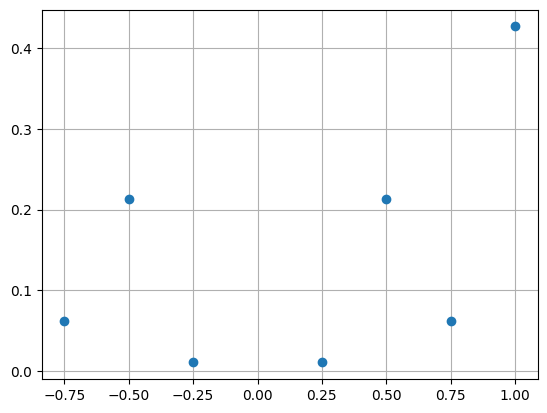

In [29]:
# Theta dans [-1., 1.]
theta = 0.25
# Création de l'unitaire U
U1 = RZ(2 * np.pi * theta)
# Nombre de qubits pour U
n = 1
# Nombre de qubits pour encoder les valeurs propres (-theta, theta)
m = 3

circuit = get_eigenvalues(n, m, U1)
states, probas = get_result(circuit, idx=[0,1,2])
states = binary_to_double(m, states)
plt.plot(states, probas, "o")
plt.grid()
plt.show()

**Question 10** : Expérimenter avec d'autres valeurs de $\theta$. Pourquoi le choix de $m$ est important pour obtenir en sortie une bonne estimation des valeurs propres ?

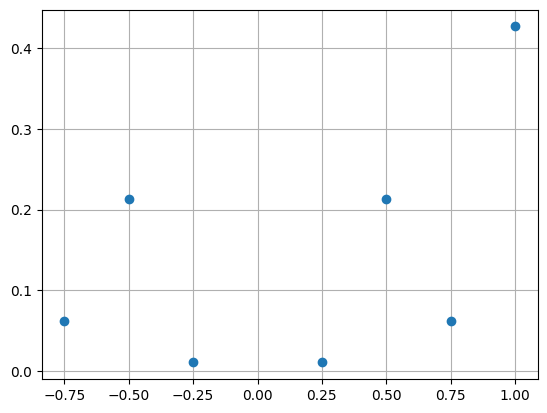

In [30]:
# Theta dans [-1., 1.]
theta = 0.25
# Création de l'unitaire U
U1 = RZ(2 * np.pi * theta)
# Nombre de qubits pour U
n = 1
# Nombre de qubits pour encoder les valeurs propres (-theta, theta)
m = 3

circuit = get_eigenvalues(n, m, U1)
states, probas = get_result(circuit, idx=[i for i in range(m)])
states = binary_to_double(m, states)
plt.plot(states, probas, "o")
plt.grid()
plt.show()

On va maintenant essayer sur un opérateur agissant sur 2 qubits. Le circuit quantique est le suivant

In [32]:
def U2(theta1, theta2):
    rout = QRoutine()
    qubits = rout.new_wires(2)

    RZ(2 * np.pi * theta1)(qubits[0])
    RZ(2 * np.pi * theta2)(qubits[1])

    return rout

**Question 11**: Déterminer les valeurs propres de U2 pour
- $\theta_1 = 0.25, \; \theta_2 = 0.125$
- $\theta_1 = 0.1875, \; \theta_2 = 0.125$

In [33]:
# Nombre de qubits pour U
n = 2
# Nombre de qubits pour encoder les valeurs propres
m = 4

# Thetas dans [-1., 1.]
theta1, theta2 = 0.25, 0.125

circuit = get_eigenvalues(n, m, U2(theta1, theta2))
states, probas = get_result(circuit, idx=[i for i in range(m)])
states = binary_to_double(m, states)
print(states, probas)

[ 0.125  0.25   0.375  0.5    0.625  0.75   0.875  1.    -0.875 -0.75
 -0.625 -0.5   -0.375 -0.25  -0.125] [0.00100583 0.02676202 0.01859734 0.11528895 0.04165485 0.15598046
 0.0254216  0.2305779  0.0254216  0.15598046 0.04165485 0.11528895
 0.01859734 0.02676202 0.00100583]


## Pour aller plus loin
- L'algorithme de Shor [https://fr.wikipedia.org/wiki/Algorithme_de_Shor] proposé en 1994 par Peter Shor permet de factoriser un entier naturel $N$ en deux autres entiers. Cet algorithme permet de casser de nombreux codes cyptographiques tel que RSA. Cet algorithme repose notamment sur la QFT que nous avons implémentée durant ce TP. L'idée est que si nous ne sommes pas en mesure de factoriser triviallement $N$ à l'aide de ressources classiques nous pouvons utiliser l'ordinateur quantique pour cette tache.

1) Prendre un nombre pseudo-aléatoire $a < N$
2) Calculer $PGCD(a, N)$. Si $a$ et $N$ ne sont pas premiers entre eux on a trouvé un facteur non trivial de $N$ et on s'arrête là
3) Utiliser un programme quantique qui repose sur la QFT pour trouver la période $r$ de la fonction $f(x) = a^x mod N$
4) A partir de $r$ déterminer un facteur de $N$, si c'est impossible retourner à l'étape 1

En pratique, nous sommes encore très loin d'avoir les ordinateurs quantiques suffisamment puissant et tolérants aux erreurs pour craquer des codes comme RSA. Le plus grand nombre factorisé à l'heure actuelle avec des ressources quantiques en utilisant l'algorithme de Shor ne dépasse pas 21 et en trichant.